In [1]:
## lets import necessary packages
## conda env compare_PSD
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV

In [2]:
## Lets load the data

full_df = pd.read_pickle("full_df_2021_CO2.pkl")
pd.set_option('display.max_columns', None)

## This the data cleaning. Keeping only the relevant features and removing the less than equal to zero target values

cols_1=[i for i in range(1,16) ] ## an example of list comprehension
cols_2=[i for i in range(17,22)]
cols=cols_1+cols_2
cols.append(23)

df1= full_df.drop(full_df.columns[cols], axis=1) ## delete these columns

j=[]
for i in range(4,72):
    j.append(i)

df2 = df1.drop(df1.columns[j], axis=1)
df3 = df2.drop(df2.columns[[11,12,13,14,15,16,17,18]], axis=1)

## we will need to treat the \ character as a \ character rather 
## than escape character, so the letter r needs to be added before the string


df3.rename(columns={'pda': 'Average Pupil Diameter (mm)', 'pup_dis': 'Pupil Distance (mm)',
                    'pd_diff_abs': '|Difference in Pupil Diameter| (mm)', 'ECG.': r'ECG ($\mathrm{\mu V}$)',
                    'Resp.': 'Respiration Rate (brpm)','Temp.': r'Skin Temperature ($\mathrm{^o C})$',
                    'HR': 'Heart Rate (bpm)','CO2':r'$\mathrm{CO_2}$ (ppm)','SpO2':r'$\mathrm{SpO_2}$ (%)',
                    'GSR':r'GSR ($\mathrm{\mu S}$)'}, inplace=True)

## Lets change some of variables to standard units

df3[r'$\mathrm{SpO_2}$ (%)']=df3[r'$\mathrm{SpO_2}$ (%)']*1000000 ## change the SpO2 to percentage

df3[r'GSR ($\mathrm{\mu S}$)']=df3[r'GSR ($\mathrm{\mu S}$)']*1000 ## convert kiloohms to ohms
df3[r'GSR ($\mathrm{\mu S}$)']=1/df3[r'GSR ($\mathrm{\mu S}$)']  ## convert ohms to siemans by taking the reciprocal
df3[r'GSR ($\mathrm{\mu S}$)']=df3[r'GSR ($\mathrm{\mu S}$)']*1000000 ## convert siemens to microsiemens

df3 = df3.drop(df3.columns[6], axis=1) ## drop the PPG as physical interpration was difficult. Also, it was used to measure SpO2 by the sensor
df3

j=[]
for i in range(10,330):
    j.append(i)
  
df3= df3.drop(df3.columns[j], axis=1)
df3= df3.drop(df3.columns[3], axis=1)


main_df=df3
main_df   

,$\mathrm{CO_2}$ (ppm),Average Pupil Diameter (mm),Pupil Distance (mm),ECG ($\mathrm{\mu V}$),Respiration Rate (brpm),$\mathrm{SpO_2}$ (%),Heart Rate (bpm),GSR ($\mathrm{\mu S}$),Skin Temperature ($\mathrm{^o C})$
dateTime,,,,,,,,,
2021-06-09 10:55:43.047,347.151,4.770,65.72,-0.002129,36.954880,99.0,72.0,0.085379,31.2500
2021-06-09 10:55:44.046,347.386,4.770,65.77,-0.002145,37.000731,99.0,72.0,0.085404,31.1875
2021-06-09 10:55:45.046,346.418,4.240,65.28,-0.002531,37.229978,100.0,72.0,0.085379,31.1250
2021-06-09 10:55:53.046,347.109,4.140,65.84,-0.002252,36.679782,99.0,72.0,0.085276,31.2500
2021-06-09 10:55:54.046,346.136,4.450,65.85,-0.002217,36.542233,98.0,73.0,0.085250,31.0625
...,...,...,...,...,...,...,...,...,...
2021-06-10 11:27:04.678,892.025,2.465,64.57,-0.001057,27.739085,97.0,124.0,0.092703,29.4375
2021-06-10 11:27:05.673,891.586,2.590,65.62,-0.000833,27.739085,97.0,124.0,0.093008,29.5000
2021-06-10 11:27:06.678,891.690,2.720,65.93,-0.000821,28.060032,98.0,124.0,0.092886,29.5625


In [3]:
## lets load the new PSD dataframe

new_psd=pd.read_pickle('../PB_PSD/PSD_9_10_PB.pkl')
new_psd

,Fp1-delta_TW,Fp1-theta_TW,Fp1-alpha_TW,Fp1-beta_TW,Fp1-gamma_TW,Fp2-delta_TW,Fp2-theta_TW,Fp2-alpha_TW,Fp2-beta_TW,Fp2-gamma_TW,F3-delta_TW,F3-theta_TW,F3-alpha_TW,F3-beta_TW,F3-gamma_TW,F4-delta_TW,F4-theta_TW,F4-alpha_TW,F4-beta_TW,F4-gamma_TW,C3-delta_TW,C3-theta_TW,C3-alpha_TW,C3-beta_TW,C3-gamma_TW,C4-delta_TW,C4-theta_TW,C4-alpha_TW,C4-beta_TW,C4-gamma_TW,P3-delta_TW,P3-theta_TW,P3-alpha_TW,P3-beta_TW,P3-gamma_TW,P4-delta_TW,P4-theta_TW,P4-alpha_TW,P4-beta_TW,P4-gamma_TW,O1-delta_TW,O1-theta_TW,O1-alpha_TW,O1-beta_TW,O1-gamma_TW,O2-delta_TW,O2-theta_TW,O2-alpha_TW,O2-beta_TW,O2-gamma_TW,F7-delta_TW,F7-theta_TW,F7-alpha_TW,F7-beta_TW,F7-gamma_TW,F8-delta_TW,F8-theta_TW,F8-alpha_TW,F8-beta_TW,F8-gamma_TW,T7-delta_TW,T7-theta_TW,T7-alpha_TW,T7-beta_TW,T7-gamma_TW,T8-delta_TW,T8-theta_TW,T8-alpha_TW,T8-beta_TW,T8-gamma_TW,P7-delta_TW,P7-theta_TW,P7-alpha_TW,P7-beta_TW,P7-gamma_TW,P8-delta_TW,P8-theta_TW,P8-alpha_TW,P8-beta_TW,P8-gamma_TW,Fz-delta_TW,Fz-theta_TW,Fz-alpha_TW,Fz-beta_TW,Fz-gamma_TW,Cz-delta_TW,Cz-theta_TW,Cz-alpha_TW,Cz-beta_TW,Cz-gamma_TW,Pz-delta_TW,Pz-theta_TW,Pz-alpha_TW,Pz-beta_TW,Pz-gamma_TW,Oz-delta_TW,Oz-theta_TW,Oz-alpha_TW,Oz-beta_TW,Oz-gamma_TW,FC1-delta_TW,FC1-theta_TW,FC1-alpha_TW,FC1-beta_TW,FC1-gamma_TW,FC2-delta_TW,FC2-theta_TW,FC2-alpha_TW,FC2-beta_TW,FC2-gamma_TW,CP1-delta_TW,CP1-theta_TW,CP1-alpha_TW,CP1-beta_TW,CP1-gamma_TW,CP2-delta_TW,CP2-theta_TW,CP2-alpha_TW,CP2-beta_TW,CP2-gamma_TW,FC5-delta_TW,FC5-theta_TW,FC5-alpha_TW,FC5-beta_TW,FC5-gamma_TW,FC6-delta_TW,FC6-theta_TW,FC6-alpha_TW,FC6-beta_TW,FC6-gamma_TW,CP5-delta_TW,CP5-theta_TW,CP5-alpha_TW,CP5-beta_TW,CP5-gamma_TW,CP6-delta_TW,CP6-theta_TW,CP6-alpha_TW,CP6-beta_TW,CP6-gamma_TW,FT9-delta_TW,FT9-theta_TW,FT9-alpha_TW,FT9-beta_TW,FT9-gamma_TW,FT10-delta_TW,FT10-theta_TW,FT10-alpha_TW,FT10-beta_TW,FT10-gamma_TW,FCz-delta_TW,FCz-theta_TW,FCz-alpha_TW,FCz-beta_TW,FCz-gamma_TW,AFz-delta_TW,AFz-theta_TW,AFz-alpha_TW,AFz-beta_TW,AFz-gamma_TW,F1-delta_TW,F1-theta_TW,F1-alpha_TW,F1-beta_TW,F1-gamma_TW,F2-delta_TW,F2-theta_TW,F2-alpha_TW,F2-beta_TW,F2-gamma_TW,C1-delta_TW,C1-theta_TW,C1-alpha_TW,C1-beta_TW,C1-gamma_TW,C2-delta_TW,C2-theta_TW,C2-alpha_TW,C2-beta_TW,C2-gamma_TW,P1-delta_TW,P1-theta_TW,P1-alpha_TW,P1-beta_TW,P1-gamma_TW,P2-delta_TW,P2-theta_TW,P2-alpha_TW,P2-beta_TW,P2-gamma_TW,AF3-delta_TW,AF3-theta_TW,AF3-alpha_TW,AF3-beta_TW,AF3-gamma_TW,AF4-delta_TW,AF4-theta_TW,AF4-alpha_TW,AF4-beta_TW,AF4-gamma_TW,FC3-delta_TW,FC3-theta_TW,FC3-alpha_TW,FC3-beta_TW,FC3-gamma_TW,FC4-delta_TW,FC4-theta_TW,FC4-alpha_TW,FC4-beta_TW,FC4-gamma_TW,CP3-delta_TW,CP3-theta_TW,CP3-alpha_TW,CP3-beta_TW,CP3-gamma_TW,CP4-delta_TW,CP4-theta_TW,CP4-alpha_TW,CP4-beta_TW,CP4-gamma_TW,PO3-delta_TW,PO3-theta_TW,PO3-alpha_TW,PO3-beta_TW,PO3-gamma_TW,PO4-delta_TW,PO4-theta_TW,PO4-alpha_TW,PO4-beta_TW,PO4-gamma_TW,F5-delta_TW,F5-theta_TW,F5-alpha_TW,F5-beta_TW,F5-gamma_TW,F6-delta_TW,F6-theta_TW,F6-alpha_TW,F6-beta_TW,F6-gamma_TW,C5-delta_TW,C5-theta_TW,C5-alpha_TW,C5-beta_TW,C5-gamma_TW,C6-delta_TW,C6-theta_TW,C6-alpha_TW,C6-beta_TW,C6-gamma_TW,P5-delta_TW,P5-theta_TW,P5-alpha_TW,P5-beta_TW,P5-gamma_TW,P6-delta_TW,P6-theta_TW,P6-alpha_TW,P6-beta_TW,P6-gamma_TW,AF7-delta_TW,AF7-theta_TW,AF7-alpha_TW,AF7-beta_TW,AF7-gamma_TW,AF8-delta_TW,AF8-theta_TW,AF8-alpha_TW,AF8-beta_TW,AF8-gamma_TW,FT7-delta_TW,FT7-theta_TW,FT7-alpha_TW,FT7-beta_TW,FT7-gamma_TW,FT8-delta_TW,FT8-theta_TW,FT8-alpha_TW,FT8-beta_TW,FT8-gamma_TW,TP7-delta_TW,TP7-theta_TW,TP7-alpha_TW,TP7-beta_TW,TP7-gamma_TW,TP8-delta_TW,TP8-theta_TW,TP8-alpha_TW,TP8-beta_TW,TP8-gamma_TW,PO7-delta_TW,PO7-theta_TW,PO7-alpha_TW,PO7-beta_TW,PO7-gamma_TW,PO8-delta_TW,PO8-theta_TW,PO8-alpha_TW,PO8-beta_TW,PO8-gamma_TW,Fpz-delta_TW,Fpz-theta_TW,Fpz-alpha_TW,Fpz-beta_TW,Fpz-gamma_TW,CPz-delta_TW,CPz-theta_TW,CPz-alpha_TW,CPz-beta_TW,CPz-gamma_TW,POz-delta_TW,POz-theta_TW,POz-alpha_TW,POz-beta_TW,POz-gamma_TW,TP10-delta_TW,TP10-theta_TW,TP10-alpha_TW,TP10-beta_TW,TP10-gamma_TW
dateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [4]:
## lets merge it

tol_2 = pd.Timedelta('1s')
full_df = pd.merge_asof(left=main_df, right=new_psd, right_index=True, left_index=True, direction='nearest', tolerance=tol_2)
full_df
df3=full_df
df3

,$\mathrm{CO_2}$ (ppm),Average Pupil Diameter (mm),Pupil Distance (mm),ECG ($\mathrm{\mu V}$),Respiration Rate (brpm),$\mathrm{SpO_2}$ (%),Heart Rate (bpm),GSR ($\mathrm{\mu S}$),Skin Temperature ($\mathrm{^o C})$,Fp1-delta_TW,Fp1-theta_TW,Fp1-alpha_TW,Fp1-beta_TW,Fp1-gamma_TW,Fp2-delta_TW,Fp2-theta_TW,Fp2-alpha_TW,Fp2-beta_TW,Fp2-gamma_TW,F3-delta_TW,F3-theta_TW,F3-alpha_TW,F3-beta_TW,F3-gamma_TW,F4-delta_TW,F4-theta_TW,F4-alpha_TW,F4-beta_TW,F4-gamma_TW,C3-delta_TW,C3-theta_TW,C3-alpha_TW,C3-beta_TW,C3-gamma_TW,C4-delta_TW,C4-theta_TW,C4-alpha_TW,C4-beta_TW,C4-gamma_TW,P3-delta_TW,P3-theta_TW,P3-alpha_TW,P3-beta_TW,P3-gamma_TW,P4-delta_TW,P4-theta_TW,P4-alpha_TW,P4-beta_TW,P4-gamma_TW,O1-delta_TW,O1-theta_TW,O1-alpha_TW,O1-beta_TW,O1-gamma_TW,O2-delta_TW,O2-theta_TW,O2-alpha_TW,O2-beta_TW,O2-gamma_TW,F7-delta_TW,F7-theta_TW,F7-alpha_TW,F7-beta_TW,F7-gamma_TW,F8-delta_TW,F8-theta_TW,F8-alpha_TW,F8-beta_TW,F8-gamma_TW,T7-delta_TW,T7-theta_TW,T7-alpha_TW,T7-beta_TW,T7-gamma_TW,T8-delta_TW,T8-theta_TW,T8-alpha_TW,T8-beta_TW,T8-gamma_TW,P7-delta_TW,P7-theta_TW,P7-alpha_TW,P7-beta_TW,P7-gamma_TW,P8-delta_TW,P8-theta_TW,P8-alpha_TW,P8-beta_TW,P8-gamma_TW,Fz-delta_TW,Fz-theta_TW,Fz-alpha_TW,Fz-beta_TW,Fz-gamma_TW,Cz-delta_TW,Cz-theta_TW,Cz-alpha_TW,Cz-beta_TW,Cz-gamma_TW,Pz-delta_TW,Pz-theta_TW,Pz-alpha_TW,Pz-beta_TW,Pz-gamma_TW,Oz-delta_TW,Oz-theta_TW,Oz-alpha_TW,Oz-beta_TW,Oz-gamma_TW,FC1-delta_TW,FC1-theta_TW,FC1-alpha_TW,FC1-beta_TW,FC1-gamma_TW,FC2-delta_TW,FC2-theta_TW,FC2-alpha_TW,FC2-beta_TW,FC2-gamma_TW,CP1-delta_TW,CP1-theta_TW,CP1-alpha_TW,CP1-beta_TW,CP1-gamma_TW,CP2-delta_TW,CP2-theta_TW,CP2-alpha_TW,CP2-beta_TW,CP2-gamma_TW,FC5-delta_TW,FC5-theta_TW,FC5-alpha_TW,FC5-beta_TW,FC5-gamma_TW,FC6-delta_TW,FC6-theta_TW,FC6-alpha_TW,FC6-beta_TW,FC6-gamma_TW,CP5-delta_TW,CP5-theta_TW,CP5-alpha_TW,CP5-beta_TW,CP5-gamma_TW,CP6-delta_TW,CP6-theta_TW,CP6-alpha_TW,CP6-beta_TW,CP6-gamma_TW,FT9-delta_TW,FT9-theta_TW,FT9-alpha_TW,FT9-beta_TW,FT9-gamma_TW,FT10-delta_TW,FT10-theta_TW,FT10-alpha_TW,FT10-beta_TW,FT10-gamma_TW,FCz-delta_TW,FCz-theta_TW,FCz-alpha_TW,FCz-beta_TW,FCz-gamma_TW,AFz-delta_TW,AFz-theta_TW,AFz-alpha_TW,AFz-beta_TW,AFz-gamma_TW,F1-delta_TW,F1-theta_TW,F1-alpha_TW,F1-beta_TW,F1-gamma_TW,F2-delta_TW,F2-theta_TW,F2-alpha_TW,F2-beta_TW,F2-gamma_TW,C1-delta_TW,C1-theta_TW,C1-alpha_TW,C1-beta_TW,C1-gamma_TW,C2-delta_TW,C2-theta_TW,C2-alpha_TW,C2-beta_TW,C2-gamma_TW,P1-delta_TW,P1-theta_TW,P1-alpha_TW,P1-beta_TW,P1-gamma_TW,P2-delta_TW,P2-theta_TW,P2-alpha_TW,P2-beta_TW,P2-gamma_TW,AF3-delta_TW,AF3-theta_TW,AF3-alpha_TW,AF3-beta_TW,AF3-gamma_TW,AF4-delta_TW,AF4-theta_TW,AF4-alpha_TW,AF4-beta_TW,AF4-gamma_TW,FC3-delta_TW,FC3-theta_TW,FC3-alpha_TW,FC3-beta_TW,FC3-gamma_TW,FC4-delta_TW,FC4-theta_TW,FC4-alpha_TW,FC4-beta_TW,FC4-gamma_TW,CP3-delta_TW,CP3-theta_TW,CP3-alpha_TW,CP3-beta_TW,CP3-gamma_TW,CP4-delta_TW,CP4-theta_TW,CP4-alpha_TW,CP4-beta_TW,CP4-gamma_TW,PO3-delta_TW,PO3-theta_TW,PO3-alpha_TW,PO3-beta_TW,PO3-gamma_TW,PO4-delta_TW,PO4-theta_TW,PO4-alpha_TW,PO4-beta_TW,PO4-gamma_TW,F5-delta_TW,F5-theta_TW,F5-alpha_TW,F5-beta_TW,F5-gamma_TW,F6-delta_TW,F6-theta_TW,F6-alpha_TW,F6-beta_TW,F6-gamma_TW,C5-delta_TW,C5-theta_TW,C5-alpha_TW,C5-beta_TW,C5-gamma_TW,C6-delta_TW,C6-theta_TW,C6-alpha_TW,C6-beta_TW,C6-gamma_TW,P5-delta_TW,P5-theta_TW,P5-alpha_TW,P5-beta_TW,P5-gamma_TW,P6-delta_TW,P6-theta_TW,P6-alpha_TW,P6-beta_TW,P6-gamma_TW,AF7-delta_TW,AF7-theta_TW,AF7-alpha_TW,AF7-beta_TW,AF7-gamma_TW,AF8-delta_TW,AF8-theta_TW,AF8-alpha_TW,AF8-beta_TW,AF8-gamma_TW,FT7-delta_TW,FT7-theta_TW,FT7-alpha_TW,FT7-beta_TW,FT7-gamma_TW,FT8-delta_TW,FT8-theta_TW,FT8-alpha_TW,FT8-beta_TW,FT8-gamma_TW,TP7-delta_TW,TP7-theta_TW,TP7-alpha_TW,TP7-beta_TW,TP7-gamma_TW,TP8-delta_TW,TP8-theta_TW,TP8-alpha_TW,TP8-beta_TW,TP8-gamma_TW,PO7-delta_TW,PO7-theta_TW,PO7-alpha_TW,PO7-beta_TW,PO7-gamma_TW,PO8-delta_TW,PO8-theta_TW,PO8-alpha_TW,PO8-beta_TW,PO8-gamma_TW,Fpz-delta_TW,Fpz-theta_TW,Fpz-alpha_TW,Fpz-beta_TW,Fpz-gamma_TW,CPz-delta_TW,CPz-theta_TW,C

In [5]:
## Lets create a Train-Test set 

features=df3.drop(r'$\mathrm{CO_2}$ (ppm)',axis=1)
target=df3[r'$\mathrm{CO_2}$ (ppm)'].copy()

#from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(features, target, test_size=0.20)

In [6]:
## lets optimize these two hyperparameters

param_grid=[{'n_estimators':[80,90,100,110,120], 'max_features':[250,275,300,325]},]

In [7]:
## Lets now train the model using Random Forest Regressor 

forest_reg=RandomForestRegressor(n_jobs=-1)
grid_search=GridSearchCV(forest_reg,param_grid,cv=3,scoring="neg_mean_squared_error",return_train_score=True)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid=[{'max_features': [250, 275, 300, 325],
                          'n_estimators': [80, 90, 100, 110, 120]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [8]:
grid_search.best_estimator_   ## this is the list of best estimators. This can actually be seen above as well

RandomForestRegressor(max_features=250, n_estimators=80, n_jobs=-1)

In [9]:
## lets now select the model. This will be used later

final_model=grid_search.best_estimator_

In [10]:
final_model.fit(X_train,y_train)

## The train prediction

train_prediction_RF=final_model.predict(X_train)
RF_mse=mean_squared_error(y_train,train_prediction_RF)
RF_rmse=np.sqrt(RF_mse)
RF_rmse_train=RF_rmse

print('The train RMSE for CO2 is:::', '%.2f' % RF_rmse)

The train RMSE for CO2 is::: 3.70


In [11]:
## The test prediction

test_prediction_RF=final_model.predict(X_test)
RF_mse=mean_squared_error(y_test,test_prediction_RF)
RF_rmse=np.sqrt(RF_mse)
RF_rmse_test=RF_rmse

print('The test RMSE for CO2 is:::', '%.2f' % RF_rmse)

The test RMSE for CO2 is::: 9.57


In [12]:
### The correlation values

## The train correlation

train_r_sq=(pearsonr(y_train,train_prediction_RF)[0])**2
correlation_train=int(train_r_sq*100)/100 ## display only two digits without rounding
print(correlation_train)

## The test correlation

test_r_sq=(pearsonr(y_test,test_prediction_RF)[0])**2
correlation_test=int(test_r_sq*100)/100 ## display only two digits without rounding
print(correlation_test)

0.99
0.99


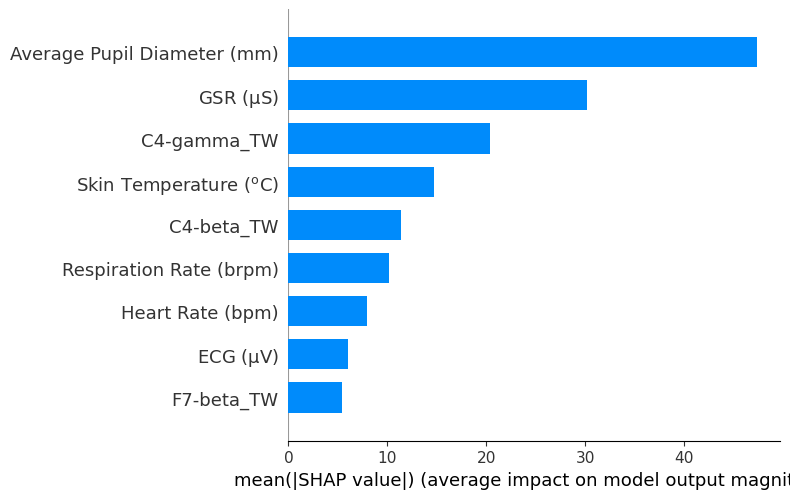

In [13]:
## displaying the feature importance using shap values

shap_values = shap.TreeExplainer(final_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar",max_display=9)

In [14]:
## steps to convert train and test to pandas dataframe. This step is necessary to plot in seaborn

y_train_np=y_train.to_numpy() ## convert dtype to numpy to plot from seaborn
y_test_np=y_test.to_numpy() 

df1=pd.DataFrame(y_train_np, columns=['Actual'])
df2=pd.DataFrame(train_prediction_RF, columns=['Estimated'])
df3=pd.concat([df1, df2],axis=1)
df3['Label']='Train'

df4=pd.DataFrame(y_test_np, columns=['Actual'])
df5=pd.DataFrame(test_prediction_RF, columns=['Estimated'])
df6=pd.concat([df4, df5],axis=1)
df6['Label']='Test'

sns_df=pd.concat([df3,df6])
sns_df

,Actual,Estimated,Label
0,843.413,843.174038,Train
1,393.451,395.280888,Train
2,411.284,411.422425,Train
3,393.199,393.096238,Train
4,394.799,395.425450,Train
...,...,...,...
459,325.965,326.122237,Test
460,407.623,408.319550,Test
461,382.796,382.841088,Test
462,536.571,538.624350,Test


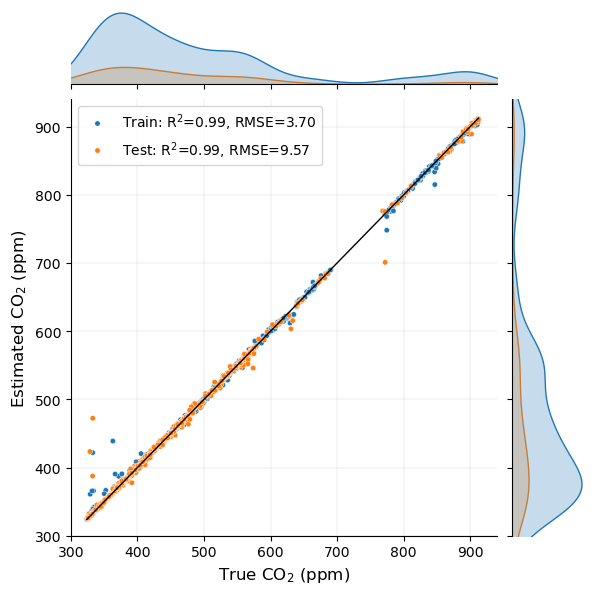

In [15]:
g=sns.jointplot(data=sns_df, x='Actual', y='Estimated', kind="scatter", hue='Label',
                 xlim=[300, 940], ylim=[300, 940], s=15)
plt.grid(axis='both',linewidth=0.15)


p1 = max(max(train_prediction_RF), max(y_train))
p2 = min(min(train_prediction_RF), min(y_train))

g.ax_joint.plot([p1, p2], [p1, p2], color='k',linewidth=1)

# Customize the legend
handles, labels = g.ax_joint.get_legend_handles_labels()


g.ax_joint.legend(handles=handles, labels=[ f'Train: R$^2$={correlation_train}, RMSE={RF_rmse_train:.2f}', 
                                               f'Test: R$^2$={correlation_test}, RMSE={RF_rmse_test:.2f}'], title=None)


g.set_axis_labels(r'True $\mathrm{CO_2}$ (ppm)', r'Estimated $\mathrm{CO_2}$ (ppm)',fontsize=12)
#plt.xlabel(r'True $\mathrm{CO_2}$ (ppm)', fontsize=15)
#plt.ylabel(r'Estimated $\mathrm{CO_2}$ (ppm)', fontsize=15)

plt.show()

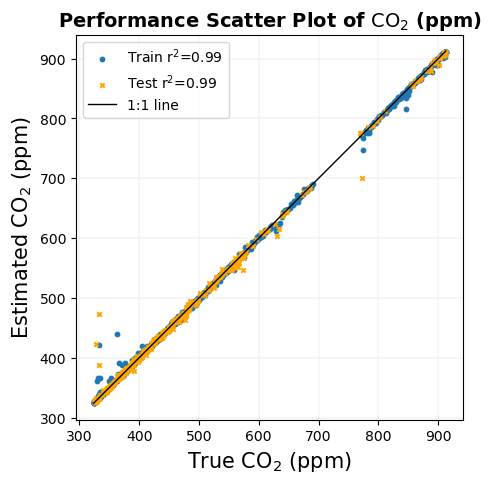

In [16]:
## Lets plot the scatter plot

import matplotlib as mpl

mpl.rcParams['mathtext.default']='regular'

plt.figure(figsize=(5,5))
plt.scatter(y_train, train_prediction_RF,s=10,c='C0',label="Train $r^2$={}".format(correlation_train))
plt.scatter(y_test, test_prediction_RF,marker='x',s=10,c='orange',label='Test $r^2$={}'.format(correlation_test))


p1 = max(max(train_prediction_RF), max(y_train))
p2 = min(min(train_prediction_RF), min(y_train))
plt.plot([p1, p2], [p1, p2], 'black',label='1:1 line',linewidth=1)
plt.xlabel(r'True $\mathrm{CO_2}$ (ppm)', fontsize=15)
plt.ylabel(r'Estimated $\mathrm{CO_2}$ (ppm)', fontsize=15)
plt.axis('equal')
plt.title(r"Performance Scatter Plot of $\mathrm{CO_2}$ (ppm)", fontsize=14,fontweight="bold")
plt.legend()
plt.grid(axis='both',linewidth=0.15)
plt.show()

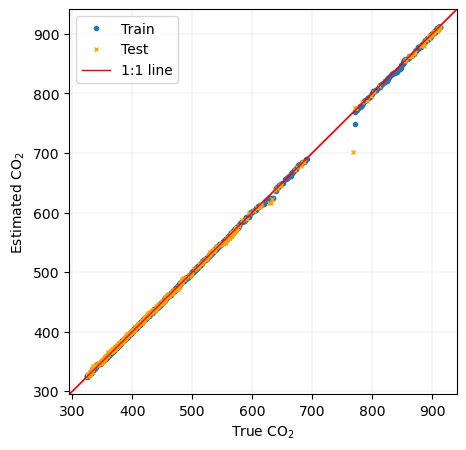

In [17]:
## Lets plot the quantile quantile 
from statsmodels.graphics.gofplots import qqplot_2samples


## This helps in customizing the graph
import statsmodels.api as sm
import scipy.stats as stats

fig, ax = plt.subplots(figsize=(5,5))

pp_x = sm.ProbPlot(y_train, fit=False)
pp_y = sm.ProbPlot(train_prediction_RF, fit=False)


qq = pp_y.qqplot(marker='o',markersize=3,other=pp_x,ax=ax, label='Train')
sm.qqline(ax=ax, line='45', fmt='r',linewidth=1)

pp_xx = sm.ProbPlot(y_test, fit=False)
pp_yy = sm.ProbPlot(test_prediction_RF, fit=False)

qqq = pp_yy.qqplot(xlabel=r'True $\mathrm{CO_2}$',ylabel=r'Estimated $\mathrm{CO_2}$',
                    marker='x',markersize=3,other=pp_xx,ax=ax,markeredgecolor = 'orange', markerfacecolor = 'orange', label='Test')
sm.qqline(qq.axes[0], line='45', fmt='r',linewidth=1, label='1:1 line')
plt.grid(axis='both',linewidth=0.15)
plt.legend()
plt.show()

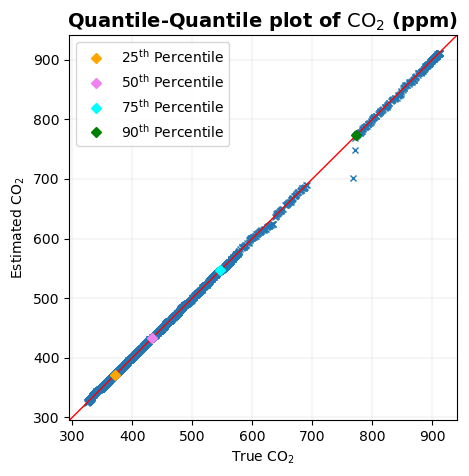

In [18]:
## Lets plot the quantile quantile 

all_preds=np.concatenate((train_prediction_RF,test_prediction_RF)) ## the list of all predictions and target values
preds=np.sort(all_preds)
tars=target.sort_values()

## This helps in customizing the graph
import statsmodels.api as sm
import scipy.stats as stats

plt.rc("figure", figsize=(5,5)) ## to make same figure size in statsmodels.api

pp_x = sm.ProbPlot(preds, fit=False)
pp_y = sm.ProbPlot(tars, fit=False)
qq = pp_x.qqplot(xlabel=r'True $\mathrm{CO_2}$',ylabel=r'Estimated $\mathrm{CO_2}$',marker='x',markersize=4,other=pp_y)

sm.qqline(qq.axes[0], line='45', fmt='r',linewidth=1)
                                 
tars_25=np.percentile(tars,25)  ## for the percentiles                                                        
tars_50=np.percentile(tars,50)
tars_75=np.percentile(tars,75)
tars_90=np.percentile(tars,90)


preds_25=np.percentile(preds,25)
preds_50=np.percentile(preds,50)
preds_75=np.percentile(preds,75)  
preds_90=np.percentile(tars,90)  ## end of percentiles

plt.plot(tars_25,preds_25,marker="D",markersize=5,color="orange",linestyle ='None',label=r"$\mathrm{25^{th}}$ Percentile")
plt.plot(tars_50,preds_50,marker="D",markersize=5,color="violet",linestyle ='None',label=r"$\mathrm{50^{th}}$ Percentile")
plt.plot(tars_75,preds_75,marker="D",markersize=5,color="Cyan",linestyle ='None',label=r"$\mathrm{75^{th}}$ Percentile")
plt.plot(tars_90,preds_90,marker="D",markersize=5,color="Green",linestyle ='None',label=r"$\mathrm{90^{th}}$ Percentile")


plt.grid(axis='both',linewidth=0.15)

plt. title(r'Quantile-Quantile plot of $\mathrm{CO_2}$ (ppm) ',fontsize=14,fontweight="bold")

plt.legend()
plt.show()


In [19]:
## lets calculate the average values of RMSE

from statistics import mean

j_train=[]
j_test=[]
k_train=[]
k_test=[]

for i in range(0,20):    
    
    X_train,X_test,y_train,y_test=train_test_split(features, target, test_size=0.20)

    final_model.fit(X_train,y_train)

    train_prediction=final_model.predict(X_train)
    mse_train=mean_squared_error(y_train,train_prediction)
    rmse_train=np.sqrt(mse_train)
    j_train.append(rmse_train)
    
    test_prediction=final_model.predict(X_test)

    mse_test=mean_squared_error(y_test,test_prediction)
    rmse_test=np.sqrt(mse_test)
    j_test.append(rmse_test)

## lets calculate the average correlation    
  
    train_r_sq=(pearsonr(y_train,train_prediction)[0])**2
    correlation_train=int(train_r_sq*100)/100 ## display just 2 of them
    k_train.append(correlation_train)
    
    test_r_sq=(pearsonr(y_test,test_prediction)[0])**2
    correlation_test=int(test_r_sq*100)/100
    k_test.append(correlation_test)

average_train_rmse=mean(j_train)
average_test_rmse=mean(j_test)
    
average_train_rsq=mean(k_train)
average_test_rsq=mean(k_test)

print('The average train RMSE for CO2 is:::', '%.2f' % average_train_rmse)
print('The average test RMSE for CO2 is:::', '%.2f' % average_test_rmse)

print('The average train r square for CO2 is:::', '%.2f' % average_train_rsq)
print('The average test r square for CO2 is:::', '%.2f' % average_test_rsq)

The average train RMSE for CO2 is::: 3.54
The average test RMSE for CO2 is::: 9.51
The average train r square for CO2 is::: 0.99
The average test r square for CO2 is::: 0.99


In [20]:
print('The test RMSE error in each of the trail is:::', j_test)

The test RMSE error in each of the trail is::: [12.645372056242335, 8.47554438027533, 7.0932332162507565, 7.812918262276237, 9.444167196838178, 7.122613239644109, 11.154437556376157, 8.982127402246876, 8.362707308609085, 14.94070260405334, 9.023188101405562, 9.717074999890304, 5.9597008319295135, 5.461856709741546, 11.694261155139653, 9.960134421595889, 12.534879239952348, 10.071800350510095, 8.290262166247366, 11.48939036548887]


In [21]:
test_rmse=pd.DataFrame(j_test, columns=['Test RMSE Error (ppm)'])
test_rmse

,Test RMSE Error (ppm)
0,12.645372
1,8.475544
2,7.093233
3,7.812918
4,9.444167
5,7.122613
6,11.154438
7,8.982127
8,8.362707
9,14.940703


In [22]:
print('The r^2 in each of the trail in test set is:::', k_test)

The r^2 in each of the trail in test set is::: [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]


In [23]:
test_r2=pd.DataFrame(k_test, columns=['R$^2$ in test set'])
test_r2

,R$^2$ in test set
0,0.99
1,0.99
2,0.99
3,0.99
4,0.99
5,0.99
6,0.99
7,0.99
8,0.99
9,0.99
